<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Script-setup" data-toc-modified-id="Script-setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Script setup</a></span></li><li><span><a href="#Data-directory-preparention" data-toc-modified-id="Data-directory-preparention-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data directory preparention</a></span></li><li><span><a href="#Data-file-preperation" data-toc-modified-id="Data-file-preperation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data file preperation</a></span><ul class="toc-item"><li><span><a href="#input-directory-(all-general-raw-data-files)" data-toc-modified-id="input-directory-(all-general-raw-data-files)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span><code>input</code> directory (all general raw data files)</a></span></li><li><span><a href="#processed-directory-(all-data-files-produced-in-this-repository)" data-toc-modified-id="processed-directory-(all-data-files-produced-in-this-repository)-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span><code>processed</code> directory (all data files produced in this repository)</a></span></li></ul></li><li><span><a href="#Load-data-functions" data-toc-modified-id="Load-data-functions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load data functions</a></span></li><li><span><a href="#Load-data-sets" data-toc-modified-id="Load-data-sets-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Load data sets</a></span></li><li><span><a href="#Power-plant-CO2-Signals" data-toc-modified-id="Power-plant-CO2-Signals-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Power plant CO2 Signals</a></span><ul class="toc-item"><li><span><a href="#Plant-Level" data-toc-modified-id="Plant-Level-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Plant Level</a></span></li><li><span><a href="#Technology-Level" data-toc-modified-id="Technology-Level-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Technology Level</a></span></li><li><span><a href="#Country-level" data-toc-modified-id="Country-level-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Country level</a></span></li><li><span><a href="#Signal-analysis" data-toc-modified-id="Signal-analysis-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Signal analysis</a></span></li><li><span><a href="#CO2-Signal-Example" data-toc-modified-id="CO2-Signal-Example-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>CO2 Signal Example</a></span></li></ul></li><li><span><a href="#ENTSO-E-generation-per-technology-CO2-Signal" data-toc-modified-id="ENTSO-E-generation-per-technology-CO2-Signal-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>ENTSO-E generation per technology CO2 Signal</a></span><ul class="toc-item"><li><span><a href="#EF-preparation" data-toc-modified-id="EF-preparation-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>EF preparation</a></span></li><li><span><a href="#Plots" data-toc-modified-id="Plots-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Plots</a></span><ul class="toc-item"><li><span><a href="#CO2-Signal-Example" data-toc-modified-id="CO2-Signal-Example-8.2.1"><span class="toc-item-num">8.2.1&nbsp;&nbsp;</span>CO2 Signal Example</a></span></li><li><span><a href="#CO2-Duration-Curves" data-toc-modified-id="CO2-Duration-Curves-8.2.2"><span class="toc-item-num">8.2.2&nbsp;&nbsp;</span>CO2 Duration Curves</a></span></li><li><span><a href="#Carbon-Intensity-Heat-Map" data-toc-modified-id="Carbon-Intensity-Heat-Map-8.2.3"><span class="toc-item-num">8.2.3&nbsp;&nbsp;</span>Carbon Intensity Heat Map</a></span></li></ul></li></ul></li><li><span><a href="#Export-final-CO2-signals" data-toc-modified-id="Export-final-CO2-signals-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Export final CO2 signals</a></span></li></ul></div>

# Introduction

This notebook uses the calculated EFs to design an different hourly CO2 emission signal for EU countries.

# Script setup

In [1]:
import os
import logging

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from IPython.display import Image 
import datetime
from matplotlib.lines import Line2D

%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 10]
sns.set_theme()

#helpers
from helpers import change_ENTSOE_ProductionTypeName

# Data directory preparention

Create input, processed and output folders if they don't exist
If the paths are relative, the corresponding folders will be created inside the current working directory.
- input -> all needed input data
- processed -> save point and exchange with other scripts
- output -> final emission factors

In [2]:
input_directory_path = os.path.join('input')
processed_directory_path = 'processed'
output_directory_path = os.path.join('output')

os.makedirs(input_directory_path, exist_ok=True)
os.makedirs(processed_directory_path, exist_ok=True)
os.makedirs(output_directory_path, exist_ok=True)

# Data file preperation

## `input` directory (all general raw data files)

- 1) ENTSO-E production per type

Production per type from ENTSO-E
Original data: ENTSO-E Transparency Platform, Actual Generation per Production Type Available online: 
https://transparency.entsoe.eu/generation/r2/actualGenerationPerProductionType/show
Processed with the following two script that converts the data to hourly resolution and scale the data to reported yearly data:

- https://github.com/Open-Power-System-Data/time_series/tree/2020-10-06
- https://github.com/INATECH-CIG/entso-e_GenerationOutputPerType

File - > entso_gen_type_hourly_table_scaled.csv -> generation per technology


- 2) ENTSO-E production per unit

Production per Unit from ENTSO-E
Original data: ENTSO-E Transparency Platform, Actual Generation per Generation Unit Available online: https://transparency.entsoe.eu/generation/r2/actualGenerationPerGenerationUnit/show (accessed on Apr 29, 2020).
Processed with the following script that converts the data to hourly resolution:

- https://github.com/INATECH-CIG/entso-e_GenerationOutputPerUnit

File - > gen_data_2018.csv -> hourly generation data per unit

File - > unit_data_2018.csv -> information about the generation units



In [3]:
# Checks if the the input directories are empty or not
# Checks all filenames in the input directory

if not os.listdir(input_directory_path) :
    print("The directory for the bootom up method is empty. Please provide the data to the directory as described in the instructions above.")


filenames = [os.path.join(input_directory_path, fn) for fn in os.listdir(input_directory_path)]

print(filenames)

['input\\bootom_up_method', 'input\\entsoe_gen_type_hourly_table.csv', 'input\\entsoe_gen_type_hourly_table_scaled.csv', 'input\\gen_data_2018.csv', 'input\\matching_ENTSOE_EU_ETS.csv', 'input\\top_down_method', 'input\\unit_data_2018.csv']


## `processed` directory (all data files produced in this repository)

- 1) EF per type and county

File - > EF_bottom_up_method.csv

- 2) EF per unit

File -> generation_unit_EF_bottom_up_method.csv

In [4]:
# Checks if the the input directories are empty or not
# Checks all filenames in the input directory

if not os.listdir(processed_directory_path) :
    print("The directory for the CO2 Signal is empty. Please provide the data to the directory as described in the instructions above.")


filenames = [os.path.join(processed_directory_path, fn) for fn in os.listdir(processed_directory_path)]

print(filenames)

['processed\\CI_0_top_down.csv', 'processed\\CI_1_top_down.csv', 'processed\\CI_bottom_up_method.csv', 'processed\\CI_MAP_1_top_down.csv', 'processed\\EF_bottom_up_method.csv', 'processed\\ei_AP_top_down.csv', 'processed\\ei_MAP_top_down.csv', 'processed\\generation_unit_EF_bottom_up_method.csv']


# Load data functions

In [5]:
def load_generation_per_unit(path, fn):
    """
    Load the ENTSO-E gernation per unit data.
        
    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename
        
    """
    
    generation = pd.read_csv(os.path.join(path, fn),sep = ',',index_col=0,parse_dates=True)
    
    return generation

def load_unit_CO2_data(path, fn):
    """
    Own generation unit information with CO2 information per unit
        
    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename
        
    """
    
    df = pd.read_csv(os.path.join(path, fn),sep = ',',index_col=0)
    
    # set name for the index
    #df.index.set_names('eic_g', inplace=True)

    return df

def load_EF(path, fn):
    """
    Own generation EF per tech and country
        
    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename
        
    """
    
    df = pd.read_csv(os.path.join(path, fn),sep = ',',index_col=[0,1])
    
    return df

def load_timeseries_ENTSOE(path, fn):
    """
    Read generation data from time-series package own modification.


    Parameters
    ----------
    path : TYPE
        DESCRIPTION.
    fn : TYPE
        DESCRIPTION.

    Returns
    -------
    generation : TYPE
        DESCRIPTION.

    """
   
    generation = (pd.read_csv(os.path.join(path, fn), index_col=[0], header=[0, 1], parse_dates=True)
                    .dropna(how="all", axis=0))
       
    
    return generation

# Load data sets

#### Load EF per technology

In [6]:
EF = load_EF(processed_directory_path, 'EF_bottom_up_method.csv')

In [7]:
EF.head(10)

EF Verified_EF  Coverage  \
MapCode ProductionTypeName                                   
AT      gas                 0.288711        True      68.0   
        hard_coal           0.884070        True      39.0   
BE      gas                 0.389641        True      64.0   
CZ      hard_coal           0.985546        True      36.0   
        lignite             0.928296        True      58.0   
DE      gas                 0.334091       False      17.0   
        hard_coal           0.871051        True      85.0   
        lignite             1.125560        True      96.0   
        other_fossil        1.619695        True      50.0   
DK      gas                 0.329783       False      10.0   

                            EF_round_in_gCO2_kwh  
MapCode ProductionTypeName                        
AT      gas                               288.71  
        hard_coal                         884.07  
BE      gas                               389.64  
CZ      hard_coal                         985.55  
        lignite                           928.30  
DE      gas                               334.09  
        hard_coal                         871.05  
        lignite                          1125.56  
        other_fossil                     1619.69  
DK      gas                               329.78

In [8]:
countries = EF.index.levels[0]

#### Load power plant generation data

In [9]:
generation_per_unit = load_generation_per_unit(input_directory_path, 'gen_data_2018.csv')

#### Load power plant emission info data

In [10]:
generation_unit_info = load_unit_CO2_data(processed_directory_path, 'generation_unit_EF_bottom_up_method.csv')

#### Load ENTSO-E generation per type

In [11]:
entsoe_gen_type = load_timeseries_ENTSOE(input_directory_path, 'entsoe_gen_type_hourly_table_scaled.csv')

#### Filter generation set to generation info data

In [12]:
generation_per_unit = generation_per_unit[generation_unit_info.index]

# Power plant CO2 Signals

In this section we build CO2 signal out of the used per power plant generation data. We limit the used generation to the generation units where we where able to calculated EFs.

In [13]:
generation_per_unit = generation_per_unit[generation_unit_info.index]

In [14]:
generation_per_unit.head(5)

,14WENERGIEAGWT4S,45W000000000032T,45W000000000033R,45W000000000034P,45W000000000040U,38W-MT--BEJG11-2,38W-MT--BEJG1Q-1,38W-KTJ-AUV-G1-8,45W000000000099Y,45W000000000037J,...,30WELCEBUCV3---X,30WTE-PARO124--W,48W000000GYAR-15,17W100P100P0171I,48W00000EGGPS-1X,48W00000EGGPS-4R,48W00000EGGPS-3T,48W00000EGGPS-2V,48W000000SUTB-1P,48W000000DEEP-1N
2018-01-01 00:00:00,0.0,20.53,0.0,0.42,0.0,149.5,0.2,271.8,0.0,0.0,...,155.97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 01:00:00,0.0,19.81,0.0,0.39,0.0,183.2,0.2,271.2,0.0,0.0,...,155.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 02:00:00,0.0,19.63,0.0,0.42,0.0,184.4,0.1,271.6,0.0,0.0,...,155.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 03:00:00,0.0,22.39,0.0,0.40,0.0,184.4,0.1,271.5,0.0,0.0,...,155.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 04:00:00,0.0,23.08,0.0,0.42,0.0,184.4,0.0,272.0,0.0,0.0,...,156.13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
generation_unit_info.head(5)

,MapCode,EUTL_countrycode,ProductionTypeName,AreaCode,AreaName,AreaTypeCode,InstalledGenCapacity,PowerSystemResourceName,ProductionUnitEIC,duplicate_count,...,VERIFIED_EMISSIONS_2009,ALLOCATION_2008,VERIFIED_EMISSIONS_2008,ACCOUNT_CLOSURE,side_generation_2018,PP_emissions_2018,PP_EF2018,EF_2018_validation,Tech_EF,Country_EF
eic_g,,,,,,,,,,,,,,,,,,,,,
14WENERGIEAGWT4S,AT,AT,gas,10YAT-APG------L,APG CA,CTA,400.0,Kraftwerk Timelkam GUD,14WENERGIE--WT02,2.0,...,340026,218704,103553,OPEN,685235.67,254778.000000,0.371811,True,0.288711,0.344882
45W000000000032T,DK,DK,hard_coal,10Y1001A1001A796,Energinet CA,CTA,147.0,Asnaesvaerket 2,45V000000000011E,1.0,...,2430356,1765318,2484733,OPEN,770018.30,202216.305002,0.922057,True,0.775840,0.751762
45W000000000033R,DK,DK,hard_coal,10Y1001A1001A796,Energinet CA,CTA,640.0,Asnaesvaerket 5,45V000000000011E,1.0,...,2430356,1765318,2484733,OPEN,770018.30,507784.694998,0.922057,True,0.775840,0.751762
45W000000000034P,DK,DK,hard_coal,10Y1001A1001A796,Energinet CA,CTA,250.0,Amagervaerket 3,45V000000000012C,1.0,...,1684995,1250995,1089604,OPEN,1060165.23,771352.000000,0.727577,True,0.775840,0.751762
45W000000000040U,DK,DK,hard_coal,10Y1001A1001A796,Energinet CA,CTA,377.0,Esbjergvaerket 3,45V0000000000164,1.0,...,1318927,1051489,1158930,OPEN,1193633.83,924609.000000,0.774617,True,0.775840,0.751762


## Plant Level

In [16]:
CO2_emission_per_unit_EF = generation_per_unit.multiply(generation_unit_info.PP_EF2018, axis='columns')

In [17]:
CO2_emission_per_unit_EF.dropna(axis=1, inplace=True)

In [18]:
CO2_emission_per_unit_EF.sum(axis=1).describe()

count      8760.000000
mean      61565.666889
std       14104.848315
min           0.000000
25%       51458.441404
50%       61425.141039
75%       71097.088567
max      101858.250203
dtype: float64

## Technology Level

In [19]:
CO2_emission_per_tech_EF = generation_per_unit.multiply((generation_unit_info.Tech_EF), axis='columns')

In [20]:
CO2_emission_per_tech_EF.dropna(axis=1, inplace=True)

In [21]:
CO2_emission_per_tech_EF.sum(axis=1).describe()

count      8760.000000
mean      61565.666889
std       14081.177708
min           0.000000
25%       51467.209805
50%       61424.233272
75%       70942.258287
max      101520.234005
dtype: float64

## Country level

In [22]:
CO2_emission_per_country_EF = generation_per_unit.multiply((generation_unit_info.Country_EF), axis='columns')

In [23]:
CO2_emission_per_country_EF.dropna(axis=1, inplace=True)

In [24]:
CO2_emission_per_country_EF.sum(axis=1).describe()

count      8760.000000
mean      61565.666889
std       15450.440543
min           0.000000
25%       49986.039862
50%       60988.251938
75%       72023.636911
max      103616.306316
dtype: float64

## Signal analysis 

#### Scatter Plot

In [25]:
Carbon_intensitiy = pd.DataFrame()
Carbon_intensitiy['unit_EF'] = ((CO2_emission_per_unit_EF * 1000000).sum(axis=1) / (generation_per_unit * 1000).sum(axis=1))
Carbon_intensitiy['tech_EF'] = ((CO2_emission_per_tech_EF * 1000000).sum(axis=1) / (generation_per_unit * 1000).sum(axis=1))
Carbon_intensitiy['country_EF'] = ((CO2_emission_per_country_EF * 1000000).sum(axis=1) / (generation_per_unit * 1000).sum(axis=1))
Carbon_intensitiy['diff_norm_unit_vs_tech'] = (Carbon_intensitiy['unit_EF'] - Carbon_intensitiy['tech_EF']) / Carbon_intensitiy['tech_EF']
Carbon_intensitiy['diff_norm_unit_vs_country'] = (Carbon_intensitiy['unit_EF'] - Carbon_intensitiy['country_EF']) / Carbon_intensitiy['country_EF']

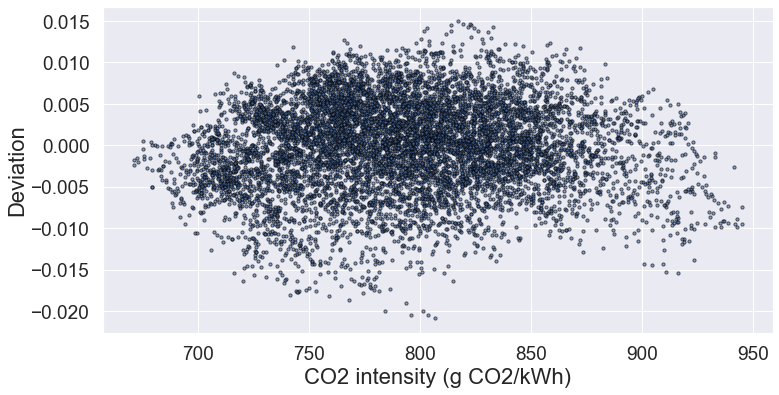

In [26]:
Carbon_intensitiy

fig,ax = plt.subplots(1,1)
    
fig.set_size_inches(12,6)


Carbon_intensitiy.plot(kind='scatter', x="tech_EF", y="diff_norm_unit_vs_tech", ax=ax, alpha=0.6, s=10, edgecolor='black', color='b')

ax.set_ylabel("Deviation", fontsize=22)
ax.set_xlabel("CO2 intensity (g CO2/kWh)" , fontsize=22)

ax.tick_params(axis='x',labelsize=19)
ax.tick_params(axis='y',labelsize=19)

pass

In [27]:
fig.savefig(os.path.join(output_directory_path + '/_CO2_intensity_deviation_tech_vs_unit.png'))

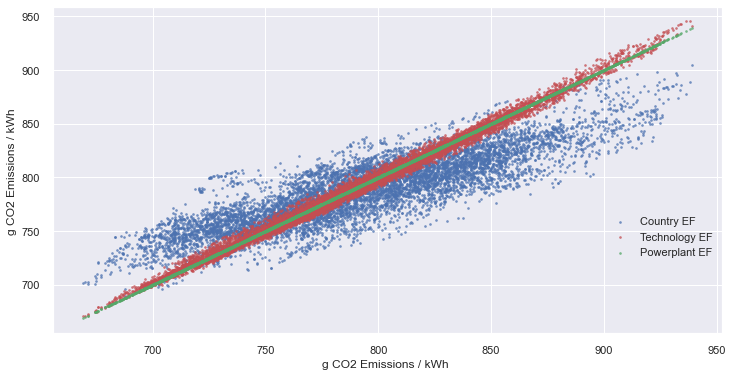

In [28]:
fig,ax = plt.subplots(1,1)
    
fig.set_size_inches(12,6)


Carbon_intensitiy.plot(kind='scatter', x="unit_EF", y="country_EF", ax=ax, alpha=0.6, color='b', s=3)

Carbon_intensitiy.plot(kind='scatter', x="unit_EF", y="tech_EF", ax=ax, alpha=0.6, color='r', s=3)

Carbon_intensitiy.plot(kind='scatter', x="unit_EF", y="unit_EF", ax=ax, alpha=0.6, color='g', s=3)



ax.set_ylabel("g CO2 Emissions / kWh ")
ax.set_xlabel("g CO2 Emissions / kWh ")

ax.legend(['Country EF', 'Technology EF', 'Powerplant EF'] ,loc='lower right', bbox_to_anchor=(1.0, 0.2))

In [29]:
Carbon_intensitiy_per_country_unit_EF = ((CO2_emission_per_unit_EF * 1000000).groupby(generation_unit_info.MapCode, axis=1).sum()) / (generation_per_unit * 1000).groupby(generation_unit_info.MapCode, axis=1).sum()
Carbon_intensitiy_per_country_tech_EF = (CO2_emission_per_tech_EF * 1000000).groupby(generation_unit_info.MapCode, axis=1).sum() / (generation_per_unit * 1000).groupby(generation_unit_info.MapCode, axis=1).sum()
Carbon_intensitiy_per_country_country_EF = (CO2_emission_per_country_EF * 1000000).groupby(generation_unit_info.MapCode, axis=1).sum() / (generation_per_unit * 1000).groupby(generation_unit_info.MapCode, axis=1).sum()

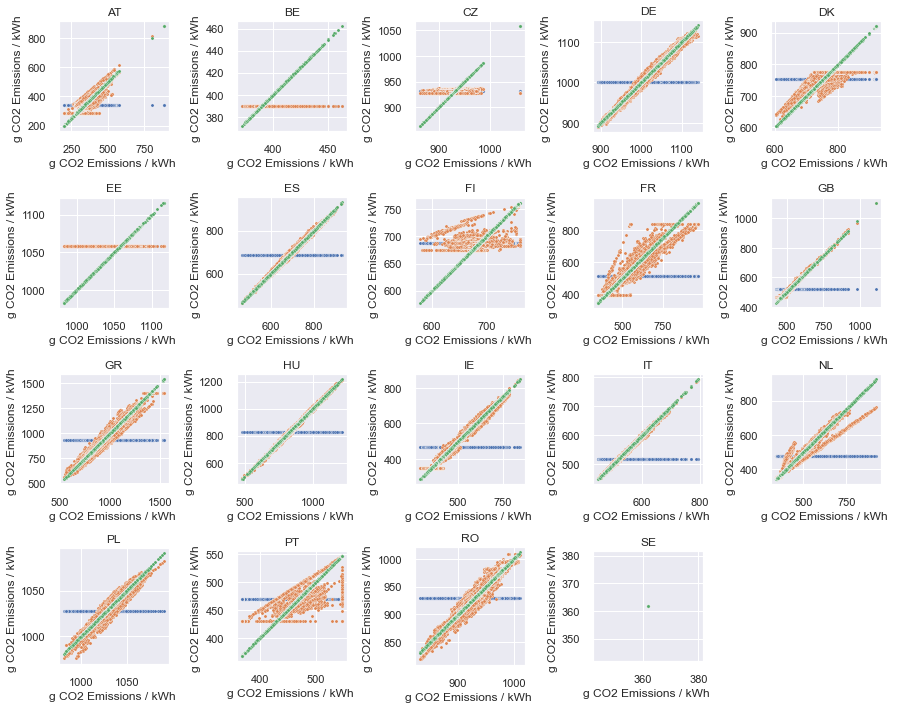

In [30]:
n_graphs = len(Carbon_intensitiy_per_country_unit_EF.columns)
n_cols = 5
    
if n_graphs % n_cols == 0:
    n_rows = n_graphs // n_cols
else:
    n_rows = n_graphs // n_cols + 1
    
    
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)

fig.delaxes(axes[3][4])

size = 2.5

fig.set_size_inches(size*n_cols,size*n_rows)
    
    
for i, country in enumerate(Carbon_intensitiy_per_country_unit_EF.columns):
    i_row = i // n_cols
    i_col = i % n_cols
        
    ax = axes[i_row,i_col]
    
    ax.set(aspect='equal')
    
    sns.scatterplot(x=Carbon_intensitiy_per_country_unit_EF.loc[:,country], y=Carbon_intensitiy_per_country_country_EF.loc[:,country], s=10, ax=ax)
    sns.scatterplot(x=Carbon_intensitiy_per_country_unit_EF.loc[:,country], y=Carbon_intensitiy_per_country_tech_EF.loc[:,country], s=10, ax=ax)
    sns.scatterplot(x=Carbon_intensitiy_per_country_unit_EF.loc[:,country], y=Carbon_intensitiy_per_country_unit_EF.loc[:,country], s=10, ax=ax)
    
        #max_lim = (max(entso_DE.loc[:,tech].max(),generation_DE.loc[:,tech].max())//1000)*1000+1000
        #if max_lim < 0:
        #    max_lim = 0
        
        #min_lim = (min(entso_DE.loc[:,tech].min(),generation_DE.loc[:,tech].min())//1000)*1000-1000
        #if min_lim < 0:
        #    min_lim = 0
    
    ax.set_title(country)
        #ax.set_xlim(min_lim,max_lim)
        #ax.set_ylim(min_lim,max_lim)
        
    ax.set_xlabel("g CO2 Emissions / kWh ")
    ax.set_ylabel("g CO2 Emissions / kWh ")
    
    fig.tight_layout()
    
ax.legend(['Country EF', 'Technology EF', 'Powerplant EF'] ,loc='lower right', bbox_to_anchor=(2.8, 0.5))

#### EF distribution

Text(0.5, 0, 'Country')

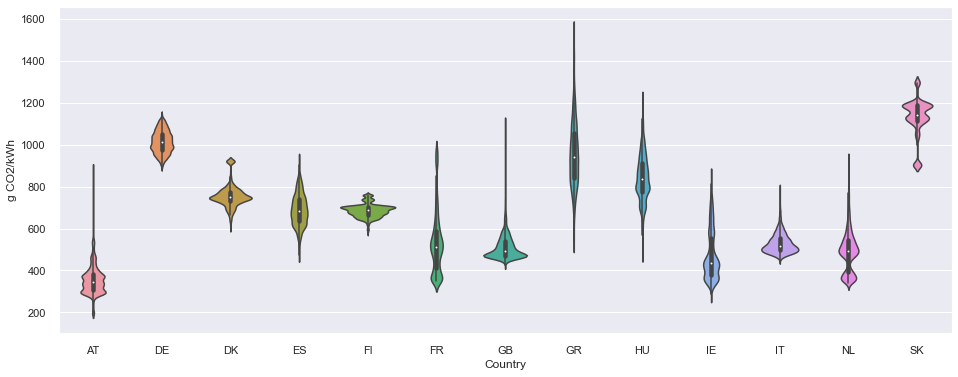

In [31]:
# per unit EF
fig,ax = plt.subplots(1,1)
    
fig.set_size_inches(16,6)
ax = sns.violinplot(data=Carbon_intensitiy_per_country_unit_EF[['AT', 'DE', 'DK', 'ES', 'FI', 'FR', 'GB', 'GR', 'HU', 'IE',
       'IT', 'NL', 'SK']])#,'BE']])

ax.set_ylabel("g CO2/kWh")
ax.set_xlabel("Country")

Text(0.5, 0, 'Country')

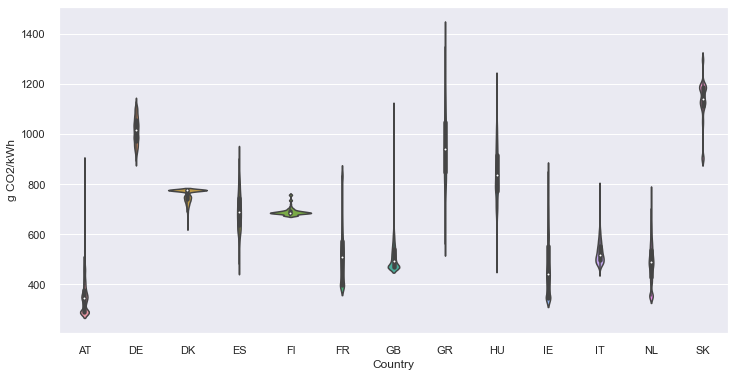

In [32]:
# per tech ef
fig,ax = plt.subplots(1,1)
    
fig.set_size_inches(12,6)

ax = sns.violinplot(data=Carbon_intensitiy_per_country_tech_EF[['AT', 'DE', 'DK', 'ES', 'FI', 'FR', 'GB', 'GR', 'HU', 'IE',
       'IT', 'NL', 'SK']])#,'BE']])

ax.set_ylabel("g CO2/kWh")
ax.set_xlabel("Country")

Text(0.5, 0, 'Country')

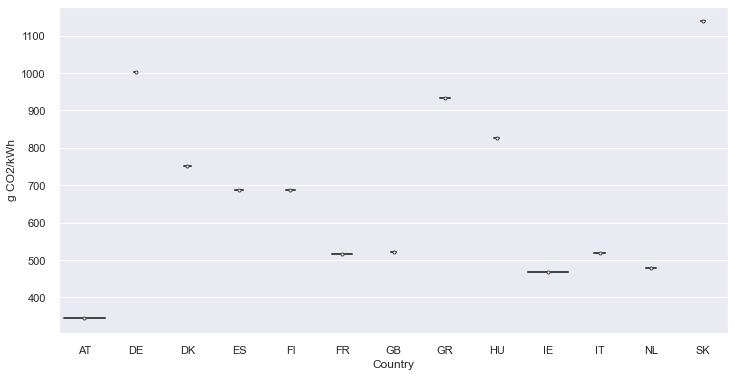

In [33]:
# per country EF
fig,ax = plt.subplots(1,1)
    
fig.set_size_inches(12,6)

ax = sns.violinplot(data=Carbon_intensitiy_per_country_country_EF[['AT', 'DE', 'DK', 'ES', 'FI', 'FR', 'GB', 'GR', 'HU', 'IE',
       'IT', 'NL', 'SK']])#,'BE']])

ax.set_ylabel("g CO2/kWh")
ax.set_xlabel("Country")

## CO2 Signal Example

The following plot shows an example of the three generated CO2 Signals

In [34]:
def plot_production_profile(generation, CO2_emission_per_unit_EF, CO2_emission_per_tech_EF, CO2_emission_per_country_EF, generators, countries, start, end):
    
    # load and filter data
    generators = generators[generators.MapCode == countries]
    generation = generation[generators.index]
    CO2_emission_per_unit_EF = CO2_emission_per_unit_EF[generators.index]
    CO2_emission_per_tech_EF = CO2_emission_per_tech_EF[generators.index]
    CO2_emission_per_country_EF = CO2_emission_per_country_EF[generators.index]
    
    # sum technologies
    generation_car =  generation.groupby(generators.ProductionTypeName, axis=1).sum()
    
    # sum Emissions
    CO2_emission_per_unit_EF = CO2_emission_per_unit_EF.sum(axis=1)
    CO2_emission_per_tech_EF = CO2_emission_per_tech_EF.sum(axis=1)
    CO2_emission_per_country_EF = CO2_emission_per_country_EF.sum(axis=1)
    
    # Carbon intensity
    Carbon_intensitiy_unit_EF = (CO2_emission_per_unit_EF * 1000000) / ((generation_car * 1000).sum(axis=1))
    Carbon_intensitiy_tech_EF = (CO2_emission_per_tech_EF * 1000000) / ((generation_car * 1000).sum(axis=1))
    Carbon_intensitiy_country_EF = (CO2_emission_per_country_EF * 1000000) / ((generation_car * 1000).sum(axis=1))
    
    #plotting
    import seaborn as sns

    sns.set(style="whitegrid")

    colors = {'gas': '#b20101',
              'biomass': '#0c6013',
              'hard_coal': '#707070',
              'geothermal': '#ba91b1',
              'lignite': '#9e5a01',
              'nuclear': '#ff9000',
              'oil': '#262626',
              'other_fossil': '#d35050',
              'waste': '#68896b',
              'onwind': '#235ebc',
              'offwind': '#6895dd',
              'solar': '#f9d002',
              'PHS': '#08ad97',
              'hydro': '#08ad97',
              'ror': '#4adbc8',
              'load': '#ea048a'}

    generation_car = generation_car.loc[start:end]
    Carbon_intensitiy_unit_EF = Carbon_intensitiy_unit_EF.loc[start:end]
    Carbon_intensitiy_tech_EF = Carbon_intensitiy_tech_EF.loc[start:end]
    Carbon_intensitiy_country_EF = Carbon_intensitiy_country_EF.loc[start:end]


    #order of col
    #cols = ['lignite', 'hard_coal',  'gas']#, 'other_fossil']

    #p_by_carrier = p_by_carrier[cols]



    fig,ax = plt.subplots(1,1)

    fig.set_size_inches(12,6)

    generation_car.plot(kind="area",
                        ax=ax,
                        linewidth=0,
                        color=[colors[col] for col in generation_car.columns],
                        alpha=0.7)



    ax.set_ylabel("Production [MW]")
    ax.set_xlabel("Date")
    ax.legend(loc='upper right', bbox_to_anchor=(1.0, 0.5))

    #ax3 = ax.twinx()
    Carbon_intensitiy_unit_EF.plot(ax=ax, secondary_y=True, legend=False)


    Carbon_intensitiy_tech_EF.plot(ax=ax, secondary_y=True, legend=False)

    Carbon_intensitiy_country_EF.plot(ax=ax, secondary_y=True, legend=False)

    ax.right_ax.set_ylabel("Emission intensity [g CO2 / kWh]")

    #ax.set_xlim(0,snapLength-1)
    #ax.set_ylim(0,150000)
    #ax.right_ax.set_ylim(0,0.1)
    plt.tight_layout()
    
    return

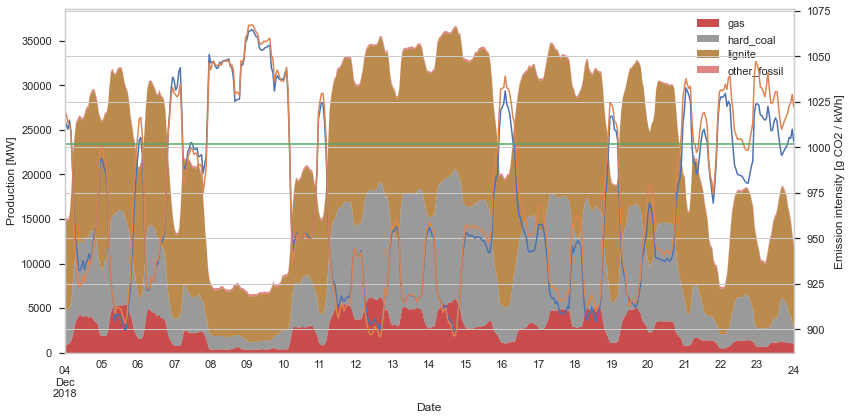

In [35]:
start = datetime.date(2018, 12, 4)
end = datetime.date(2018, 12, 24)

#Carbon_intensitiy_per_country_unit_EF
#Carbon_intensitiy_per_country_tech_EF
#Carbon_intensitiy_per_country_country_EF

plot_production_profile(generation_per_unit, CO2_emission_per_unit_EF, CO2_emission_per_tech_EF, CO2_emission_per_country_EF, generation_unit_info, 'DE', start, end)


# ENTSO-E generation per technology CO2 Signal

In this section we using the country specific EF for generating an CO2 emission signal for all EU countries. The production data are based on the production per type data from ENTSO-E

In [36]:
# take a look at the generation data
entsoe_gen_type.head(5)

region                         AT                                      \
variable                  biomass        gas   hard_coal        hydro   
utc_timestamp                                                           
2018-01-01 00:00:00+00:00   316.0  85.185998  189.813350  3633.105979   
2018-01-01 01:00:00+00:00   316.0  83.986195  188.547928  3557.076855   
2018-01-01 02:00:00+00:00   316.0  82.786393  188.547928  3439.774779   
2018-01-01 03:00:00+00:00   316.0  86.385801  188.547928  3432.171866   
2018-01-01 04:00:00+00:00   316.0  89.985209  188.547928  3616.814024   

region                                                               \
variable                  other_fossil other_renewable solar  waste   
utc_timestamp                                                         
2018-01-01 00:00:00+00:00   376.712329             NaN   0.0  100.0   
2018-01-01 01:00:00+00:00   376.712329             NaN   0.0  100.0   
2018-01-01 02:00:00+00:00   376.712329             NaN   0.0  100.0   
2018-01-01 03:00:00+00:00   376.712329             NaN   0.0  100.0   
2018-01-01 04:00:00+00:00   376.712329             NaN   0.0  100.0   

region                                          BE  ...           SI  \
variable                  wind_onshore     biomass  ... wind_onshore   
utc_timestamp                                       ...                
2018-01-01 00:00:00+00:00        832.0  310.564338  ...         0.70   
2018-01-01 01:00:00+00:00        926.0  205.181412  ...         0.61   
2018-01-01 02:00:00+00:00        692.0  178.621922  ...         0.57   
2018-01-01 03:00:00+00:00        453.0  175.522424  ...         0.62   
2018-01-01 04:00:00+00:00        321.0  175.362106  ...         0.56   

region                            SK                                     \
variable                     biomass         gas  hard_coal       hydro   
utc_timestamp                                                             
2018-01-01 00:00:00+00:00  75.757569  223.815846  71.307423  490.635794   
2018-01-01 01:00:00+00:00  75.488926  220.374486  71.159174  497.114042   
2018-01-01 02:00:00+00:00  75.488926  206.609047  69.231947  552.469700   
2018-01-01 03:00:00+00:00  79.787227  178.823253  67.156471  632.576139   
2018-01-01 04:00:00+00:00  79.249940  182.901901  68.787202  605.737684   

region                                                                        
variable                  lignite nuclear other_fossil other_renewable solar  
utc_timestamp                                                                 
2018-01-01 00:00:00+00:00   179.5  1819.3        478.8            41.4   0.0  
2018-01-01 01:00:00+00:00   177.9  1816.7        475.8            41.0   0.0  
2018-01-01 02:00:00+00:00   174.7  1808.7        469.5            40.8   0.0  
2018-01-01 03:00:00+00:00   168.5  1803.6        455.6            39.4   0.0  
2018-01-01 04:00:00+00:00   170.6  1809.1        461.5            40.4   0.0  

[5 rows x 214 columns]

## EF preparation 

In [37]:
EF

EF Verified_EF  Coverage  \
MapCode ProductionTypeName                                   
AT      gas                 0.288711        True      68.0   
        hard_coal           0.884070        True      39.0   
BE      gas                 0.389641        True      64.0   
CZ      hard_coal           0.985546        True      36.0   
        lignite             0.928296        True      58.0   
DE      gas                 0.334091       False      17.0   
        hard_coal           0.871051        True      85.0   
        lignite             1.125560        True      96.0   
        other_fossil        1.619695        True      50.0   
DK      gas                 0.329783       False      10.0   
        hard_coal           0.775840        True      69.0   
EE      other_fossil        1.057973        True     109.0   
ES      gas                 0.386506        True      48.0   
        hard_coal           0.975777        True      84.0   
FI      hard_coal           0.674454        True      69.0   
        other_fossil        0.759814       False      13.0   
FR      gas                 0.396985        True      49.0   
        hard_coal           0.834945        True      97.0   
GB      gas                 0.467992        True      56.0   
        hard_coal           1.103223        True      39.0   
GR      gas                 0.332135        True      71.0   
        lignite             1.401712        True      90.0   
HU      gas                 0.371916        True      72.0   
        lignite             1.355619        True      81.0   
IE      gas                 0.347416        True      60.0   
        hard_coal           1.032204        True      89.0   
IT      gas                 0.387735        True      50.0   
        hard_coal           0.997673        True      59.0   
NL      gas                 0.353883        True      38.0   
        hard_coal           0.948562        True      43.0   
PL      gas                 0.370311       False      10.0   
        hard_coal           0.942409        True      56.0   
        lignite             1.158647        True      78.0   
PT      gas                 0.430328        True      42.0   
        hard_coal           0.546439        True      27.0   
RO      gas                 0.315028       False      17.0   
        hard_coal           1.157439        True      72.0   
        lignite             1.000763        True      88.0   
SE      gas                 0.361805         NaN       NaN   
SK      hard_coal           0.903090        True      65.0   
        lignite             1.295547        True      87.0   

                            EF_round_in_gCO2_kwh  
MapCode ProductionTypeName                        
AT      gas                               288.71  
        hard_coal                         884.07  
BE      gas                               389.64  
CZ      hard_coal                         985.55  
        lignite                           928.30  
DE      gas                               334.09  
        hard_coal                         871.05  
        lignite                          1125.56  
        other_fossil                     1619.69  
DK      gas                               329.78  
        hard_coal                         775.84  
EE      other_fossil                     1057.97  
ES      gas                               386.51  
        hard_coal                         975.78  
FI      hard_coal                         674.45  
        other_fossil                      759.81  
FR      gas                               396.98  
        hard_coal                         834.94  
GB      gas                               467.99  
        hard_coal                        1103.22  
GR      gas                               332.13  
        lignite                          1401.71  
HU      gas                               371.92  
        lignite                          1355.62  
IE      gas                              

In [38]:
# Mean EF for all calculated countries and technologies

EF_mean = EF.groupby('ProductionTypeName').mean()

# for other fossil we have set the EF to 0.51
EF_mean.loc['other_fossil'] = 0.51
EF_mean = EF_mean.EF.to_dict()


print(EF_mean)

{'gas': 0.3665166624413151, 'hard_coal': 0.9088482292089693, 'lignite': 1.180877690651492, 'other_fossil': 0.51}


In [39]:
# If no country-specific EFs are available and also no mean EF is available for a country and technology, we use the following EFs. Source:

EF_default = {'biomass':0,
            'geothermal':0,
            'hydro':0,
            'nuclear':0,
            'oil':0.8,
            'other_renewable':0,
            'solar':0,
            'waste':0.2,
            'wind_offshore':0,
            'wind_onshore':0,
            'marine':0,
            'oil shale':0.51,
            'other_fossil': 0.51}


In [40]:
# Create a dataframe with the EF for each country and technology. If no specific EF is available, we use the default EF.
EF_multi = {}

for i in entsoe_gen_type.columns:
    if i in EF.index:
        print(str(i)+' EF')
        EF_multi[i] = EF.loc[i[0],i[1]].loc['EF']
    elif i[1] in EF_mean:
        print(str(i) +' EF_mean')
        EF_multi[i] = EF_mean[i[1]]
    else:
        print(str(i) + ' EF_default')
        EF_multi[i] = EF_default[i[1]]

('AT', 'biomass') EF_default
('AT', 'gas') EF
('AT', 'hard_coal') EF
('AT', 'hydro') EF_default
('AT', 'other_fossil') EF_mean
('AT', 'other_renewable') EF_default
('AT', 'solar') EF_default
('AT', 'waste') EF_default
('AT', 'wind_onshore') EF_default
('BE', 'biomass') EF_default
('BE', 'gas') EF
('BE', 'hydro') EF_default
('BE', 'nuclear') EF_default
('BE', 'other_fossil') EF_mean
('BE', 'solar') EF_default
('BE', 'waste') EF_default
('BE', 'wind_offshore') EF_default
('BE', 'wind_onshore') EF_default
('BG', 'biomass') EF_default
('BG', 'gas') EF_mean
('BG', 'hard_coal') EF_mean
('BG', 'hydro') EF_default
('BG', 'lignite') EF_mean
('BG', 'nuclear') EF_default
('BG', 'solar') EF_default
('BG', 'waste') EF_default
('BG', 'wind_onshore') EF_default
('CH', 'hydro') EF_default
('CH', 'nuclear') EF_default
('CH', 'solar') EF_default
('CH', 'wind_onshore') EF_default
('CY', 'other_fossil') EF_mean
('CY', 'wind_onshore') EF_default
('CZ', 'biomass') EF_default
('CZ', 'gas') EF_mean
('CZ', 'ha

In [41]:
# calculate emissions based on EF and generation per type
CO2_emission_entsoe_gen_type = entsoe_gen_type * EF_multi

In [42]:
# From the previously calculated emissions, an emission signal (g CO2 / kWh) can now be calculated for each country.
# Since emissions and generation are available per technology, they must first be grouped and summed. 

# Emission in g CO2
CO2_emission = (CO2_emission_entsoe_gen_type * 1000000).groupby(level=0, axis=1).sum()
# generation in kWh
Generation = (entsoe_gen_type * 1000).groupby(level=0, axis=1).sum()

# CI in g CO2/kWh
Carbon_intensitiy_entsoe_gen_type = CO2_emission.div(Generation)

In [43]:
Carbon_intensitiy_entsoe_gen_type.head(5)

region,AT,BE,BG,CH,CY,CZ,DE,DK,EE,ES,...,ME,NL,NO,PL,PT,RO,RS,SE,SI,SK
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,73.113855,92.007514,476.774924,0.0,484.003025,384.132648,199.522307,88.776098,881.216588,107.289274,...,1180.877691,115.706888,11.081731,657.632547,114.771492,338.495967,873.453543,35.459232,268.502877,184.341019
2018-01-01 01:00:00+00:00,72.645462,96.432029,476.905109,0.0,478.453594,381.593615,198.561804,103.492504,874.456796,119.424309,...,1180.877691,115.292381,11.832607,641.524640,118.511437,331.130792,896.683891,35.800790,262.994115,183.132307
2018-01-01 02:00:00+00:00,77.507305,100.905887,477.778365,0.0,451.441402,379.121553,195.428854,97.295880,876.708520,137.149242,...,1180.877691,113.533090,13.073921,631.708066,111.393401,345.222980,903.114835,33.405632,245.005573,177.785256
2018-01-01 03:00:00+00:00,81.519916,100.150948,477.251474,0.0,450.837722,381.374413,195.845125,98.613820,887.205651,137.409571,...,1180.877691,112.353861,13.067378,634.685566,115.816605,352.562063,884.311481,33.498283,252.537386,168.400302
2018-01-01 04:00:00+00:00,80.812075,100.199220,478.449888,0.0,474.877246,386.006899,193.798527,95.878329,886.047667,138.731531,...,1180.877691,112.358109,13.000117,625.894090,116.153200,355.266892,900.631976,33.164143,254.036819,171.297685


In [44]:
mean_Carbon_intensitiy_entsoe_gen_type = CO2_emission.sum() / Generation.sum()

In [45]:
Carbon_intensitiy_entsoe_gen_type_mean = Carbon_intensitiy_entsoe_gen_type.copy()


In [46]:
for i in Carbon_intensitiy_entsoe_gen_type_mean.columns:
    Carbon_intensitiy_entsoe_gen_type_mean[i] = mean_Carbon_intensitiy_entsoe_gen_type[i]

In [47]:
Carbon_intensitiy_entsoe_gen_type_mean.head()

region,AT,BE,BG,CH,CY,CZ,DE,DK,EE,ES,...,ME,NL,NO,PL,PT,RO,RS,SE,SI,SK
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,98.307213,163.970617,522.621396,0.0,488.0195,445.541278,426.929792,220.380809,894.984693,316.319057,...,467.911146,384.649437,11.985516,829.03622,226.999397,302.405235,836.937247,27.809953,332.309961,180.472228
2018-01-01 01:00:00+00:00,98.307213,163.970617,522.621396,0.0,488.0195,445.541278,426.929792,220.380809,894.984693,316.319057,...,467.911146,384.649437,11.985516,829.03622,226.999397,302.405235,836.937247,27.809953,332.309961,180.472228
2018-01-01 02:00:00+00:00,98.307213,163.970617,522.621396,0.0,488.0195,445.541278,426.929792,220.380809,894.984693,316.319057,...,467.911146,384.649437,11.985516,829.03622,226.999397,302.405235,836.937247,27.809953,332.309961,180.472228
2018-01-01 03:00:00+00:00,98.307213,163.970617,522.621396,0.0,488.0195,445.541278,426.929792,220.380809,894.984693,316.319057,...,467.911146,384.649437,11.985516,829.03622,226.999397,302.405235,836.937247,27.809953,332.309961,180.472228
2018-01-01 04:00:00+00:00,98.307213,163.970617,522.621396,0.0,488.0195,445.541278,426.929792,220.380809,894.984693,316.319057,...,467.911146,384.649437,11.985516,829.03622,226.999397,302.405235,836.937247,27.809953,332.309961,180.472228


## Plots

This section is to see some plots for the generated and emission data

### CO2 Signal Example

In [48]:
entsoe_gen_type.columns.levels[1]

Index(['biomass', 'gas', 'hard_coal', 'hydro', 'lignite', 'nuclear',
       'other_fossil', 'other_renewable', 'solar', 'waste', 'wind_offshore',
       'wind_onshore'],
      dtype='object', name='variable')

In [49]:
def plot_production_profile_2(generation, Carbon_intensitiy, mean_Carbon_intensitiy, countries, start, end):
    
    # load and filter data
    generation = generation[countries]
    Carbon_intensitiy = Carbon_intensitiy[countries]
    Carbon_intensitiy_mean = mean_Carbon_intensitiy[countries]
    
    
    #plotting
    import seaborn as sns

    sns.set(style="whitegrid")

    colors = {'gas': '#b20101',
              'biomass': '#0c6013',
              'hard_coal': '#707070',
              'geothermal': '#ba91b1',
              'lignite': '#9e5a01',
              'nuclear': '#ff9000',
              'oil': '#262626',
              'other_fossil': '#d35050',
              'waste': '#68896b',
              'wind_onshore': '#235ebc',
              'wind_offshore': '#6895dd',
              'solar': '#f9d002',
              'PHS': '#08ad97',
              'hydro': '#08ad97',
              'ror': '#4adbc8',
              'load': '#ea048a',
              'other_renewable':'#08ad97'}

    generation = generation.loc[start:end]
    Carbon_intensitiy = Carbon_intensitiy.loc[start:end]
    Carbon_intensitiy_mean = Carbon_intensitiy_mean.loc[start:end]



    #order of col
    tech = ['biomass', 'nuclear','lignite', 'hard_coal','geothermal', 'hydro', 'gas','waste', 'oil', 'other_fossil', 'other_renewable', 'solar',  'wind_offshore', 'wind_onshore']
    
    filter = generation.columns
    
    cols = [k for k in tech if k in filter]

    generation = generation[cols]



    fig,ax = plt.subplots(1,1)

    fig.set_size_inches(16,6)

    generation.plot(kind="area",
                        ax=ax,
                        linewidth=0,
                        color=[colors[col] for col in generation.columns],
                        alpha=0.7)



    ax.set_ylabel("Production (MW)", fontsize=14)
    ax.set_xlabel("Date", fontsize=14)
    #ax.legend(loc='center left', bbox_to_anchor=(1.08, 0.5))
    ax.grid(False)
    
    ax2 = fig.add_axes() # This is the magic that joins the x-axis
    ax2 = ax.twinx()

    #ax3 = ax.twinx()
    
    Carbon_intensitiy.plot(ax=ax2, secondary_y=True, legend=False, color="k")
    Carbon_intensitiy_mean.plot(ax=ax2, secondary_y=True, legend=False, color="k", linestyle='--')    
    
        
    handles = [Line2D([0], [0], color='k', lw=2),
               Line2D([0], [0], color='k', linestyle='--', lw=2)
               ]
    
    labels = [str(countries)+ ', using technology-specific EF',str(countries) + ', using country-specific EF']
    
    l2 = ax2.legend(handles, labels,  loc='upper left', bbox_to_anchor=(1.10, 0.90),
                   handletextpad=0., columnspacing=0.5, ncol=1,
                   title='Carbon intensity', fontsize=14, frameon=True)
    
    handles = []
    labels = []
    
    for t in generation.columns:
        handles.append(plt.Line2D([0], [0], color=colors[t], marker='o', markersize=8, linewidth=0, alpha=0.7))
        labels.append(t)
        
    l3 = ax.legend(handles, labels,  bbox_to_anchor=(1.10, 0.7),
                   handletextpad=0., columnspacing=0.5, ncol=2,
                   title='Technology Types', fontsize=14, frameon=True, framealpha=0.6) #loc="upper right", 
    
    


    ax2.right_ax.set_ylabel("Carbon intensity (g CO2 / kWh)", fontsize=14)

    plt.tight_layout()
    plt.show()
    
    return fig

C:\Users\Freddy\.conda\envs\Lecture\lib\site-packages\ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.


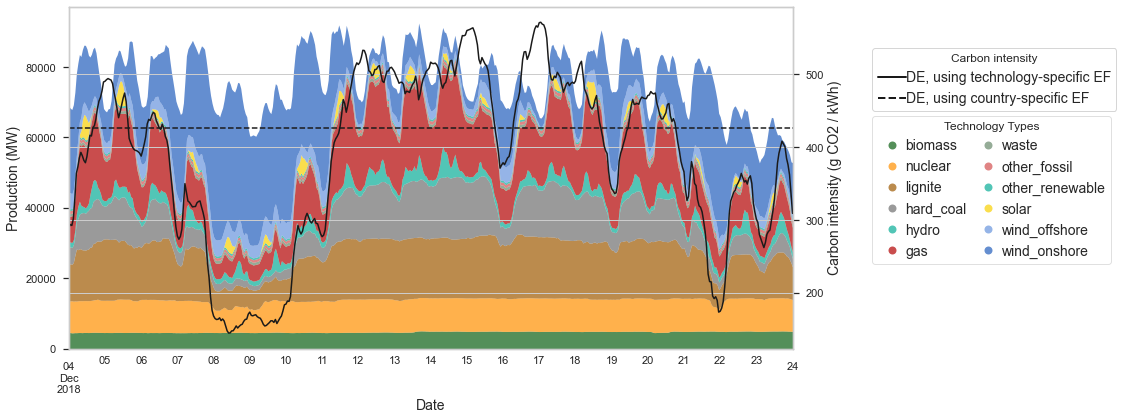

In [50]:
start = datetime.date(2018, 12, 4)
end = datetime.date(2018, 12, 24)

fig = plot_production_profile_2(entsoe_gen_type, Carbon_intensitiy_entsoe_gen_type, Carbon_intensitiy_entsoe_gen_type_mean, 'DE', start, end)

In [51]:
fig.savefig(os.path.join(output_directory_path + '/CO2_signal_example_DE.png'))

C:\Users\Freddy\.conda\envs\Lecture\lib\site-packages\ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.


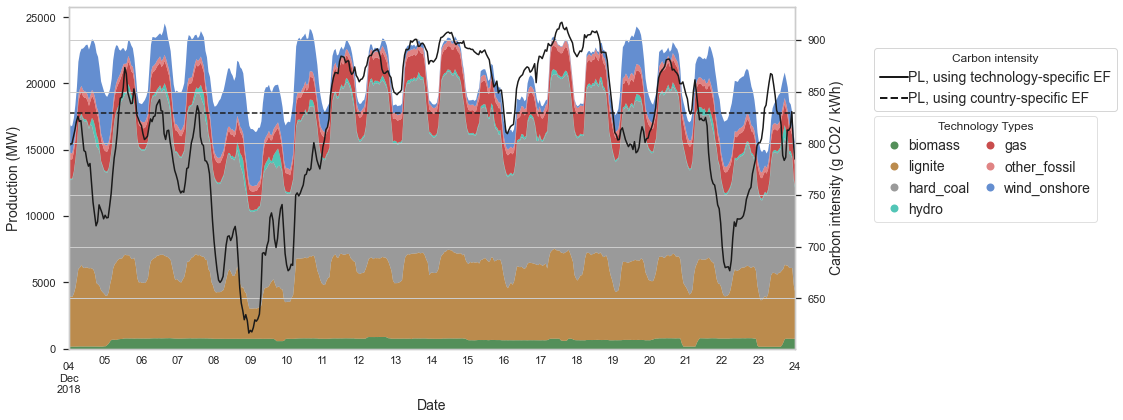

In [52]:
start = datetime.date(2018, 12, 4)
end = datetime.date(2018, 12, 24)

fig = plot_production_profile_2(entsoe_gen_type, Carbon_intensitiy_entsoe_gen_type, Carbon_intensitiy_entsoe_gen_type_mean, 'PL', start, end)

In [53]:
fig.savefig(os.path.join(output_directory_path + '/CO2_signal_example_PL.png'))

C:\Users\Freddy\.conda\envs\Lecture\lib\site-packages\ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.


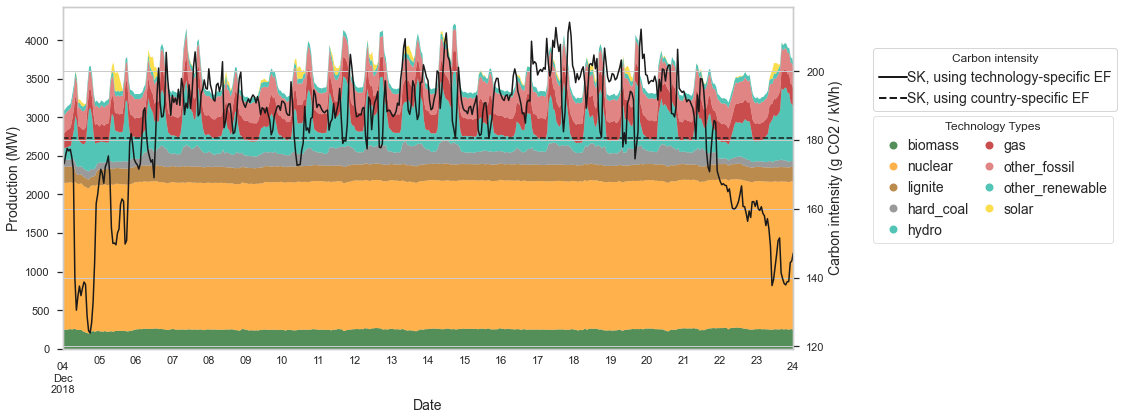

In [54]:
start = datetime.date(2018, 12, 4)
end = datetime.date(2018, 12, 24)

fig = plot_production_profile_2(entsoe_gen_type, Carbon_intensitiy_entsoe_gen_type, Carbon_intensitiy_entsoe_gen_type_mean, 'SK', start, end)

C:\Users\Freddy\.conda\envs\Lecture\lib\site-packages\ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.


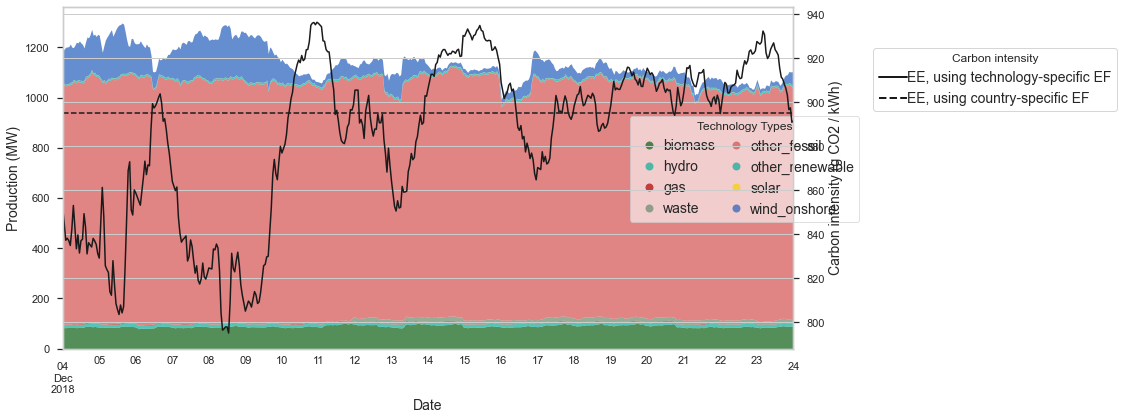

In [55]:
start = datetime.date(2018, 12, 4)
end = datetime.date(2018, 12, 24)

fig = plot_production_profile_2(entsoe_gen_type, Carbon_intensitiy_entsoe_gen_type, Carbon_intensitiy_entsoe_gen_type_mean, 'EE', start, end)

### CO2 Duration Curves

In [56]:
countries = Carbon_intensitiy_entsoe_gen_type[EF.index.levels[0]].columns

In [57]:
countries

Index(['AT', 'BE', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HU',
       'IE', 'IT', 'NL', 'PL', 'PT', 'RO', 'SE', 'SK'],
      dtype='object', name='region')

In [58]:
Carbon_intensitiy_entsoe_gen_type

region,AT,BE,BG,CH,CY,CZ,DE,DK,EE,ES,...,ME,NL,NO,PL,PT,RO,RS,SE,SI,SK
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,73.113855,92.007514,476.774924,0.0,484.003025,384.132648,199.522307,88.776098,881.216588,107.289274,...,1180.877691,115.706888,11.081731,657.632547,114.771492,338.495967,873.453543,35.459232,268.502877,184.341019
2018-01-01 01:00:00+00:00,72.645462,96.432029,476.905109,0.0,478.453594,381.593615,198.561804,103.492504,874.456796,119.424309,...,1180.877691,115.292381,11.832607,641.524640,118.511437,331.130792,896.683891,35.800790,262.994115,183.132307
2018-01-01 02:00:00+00:00,77.507305,100.905887,477.778365,0.0,451.441402,379.121553,195.428854,97.295880,876.708520,137.149242,...,1180.877691,113.533090,13.073921,631.708066,111.393401,345.222980,903.114835,33.405632,245.005573,177.785256
2018-01-01 03:00:00+00:00,81.519916,100.150948,477.251474,0.0,450.837722,381.374413,195.845125,98.613820,887.205651,137.409571,...,1180.877691,112.353861,13.067378,634.685566,115.816605,352.562063,884.311481,33.498283,252.537386,168.400302
2018-01-01 04:00:00+00:00,80.812075,100.199220,478.449888,0.0,474.877246,386.006899,193.798527,95.878329,886.047667,138.731531,...,1180.877691,112.358109,13.000117,625.894090,116.153200,355.266892,900.631976,33.164143,254.036819,171.297685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+00:00,143.079951,207.261138,624.592379,0.0,484.219640,488.942207,338.216391,115.842834,770.237886,226.889261,...,553.446262,459.930343,24.502412,741.620291,194.619886,324.992043,911.340287,41.790979,209.310601,152.268663
2018-12-31 20:00:00+00:00,143.962251,202.692671,639.959397,0.0,458.670179,490.269347,325.576135,115.029500,763.070505,229.057399,...,617.031033,458.194792,25.416560,738.537014,217.598022,322.294932,925.178235,42.776491,245.228578,154.476834
2018-12-31 21:00:00+00:00,144.586166,190.748683,639.814777,0.0,446.363323,460.854341,313.343889,107.651039,760.467441,228.274786,...,623.465548,460.648219,24.501375,725.499593,270.777268,352.582205,907.306582,43.894419,271.306049,160.610511


#### One Figure

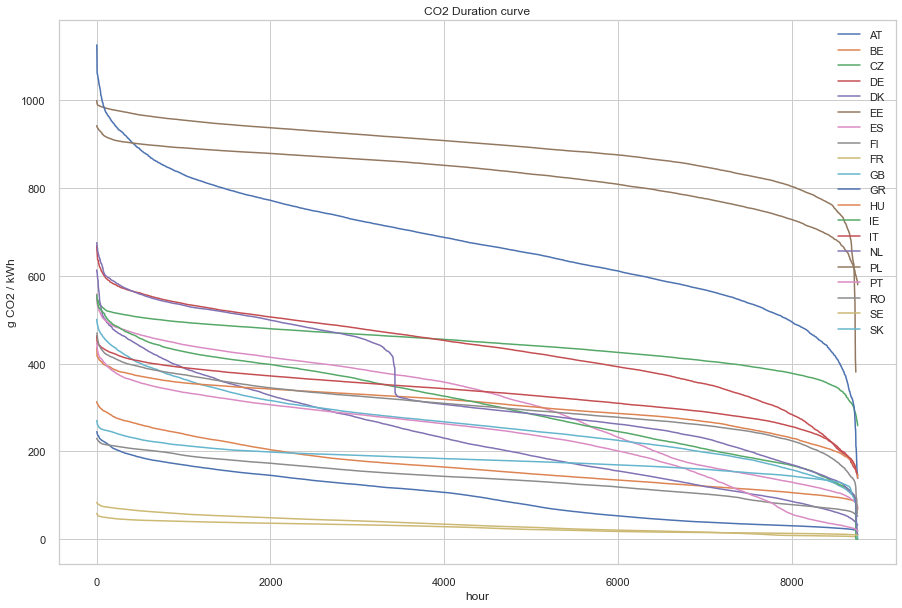

In [59]:
fig, ax = plt.subplots()

for i in countries:    
    ax.plot(range(0,8760), Carbon_intensitiy_entsoe_gen_type[i].sort_values(ascending=False), label = 'CO2 Duration curve')


    
ax.legend(countries ,loc='upper right')
ax.set_xlabel('hour')
ax.set_ylabel('g CO2 / kWh')
plt.title('CO2 Duration curve')
plt.show()

#### Multi sub Figures

In [60]:
c = ['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB',
       'GR', 'HU', 'IE', 'IT', 'LT', 'LV', 'NL', 'NO', 'PL', 'PT', 'RO', 'SE',
       'SI', 'SK']

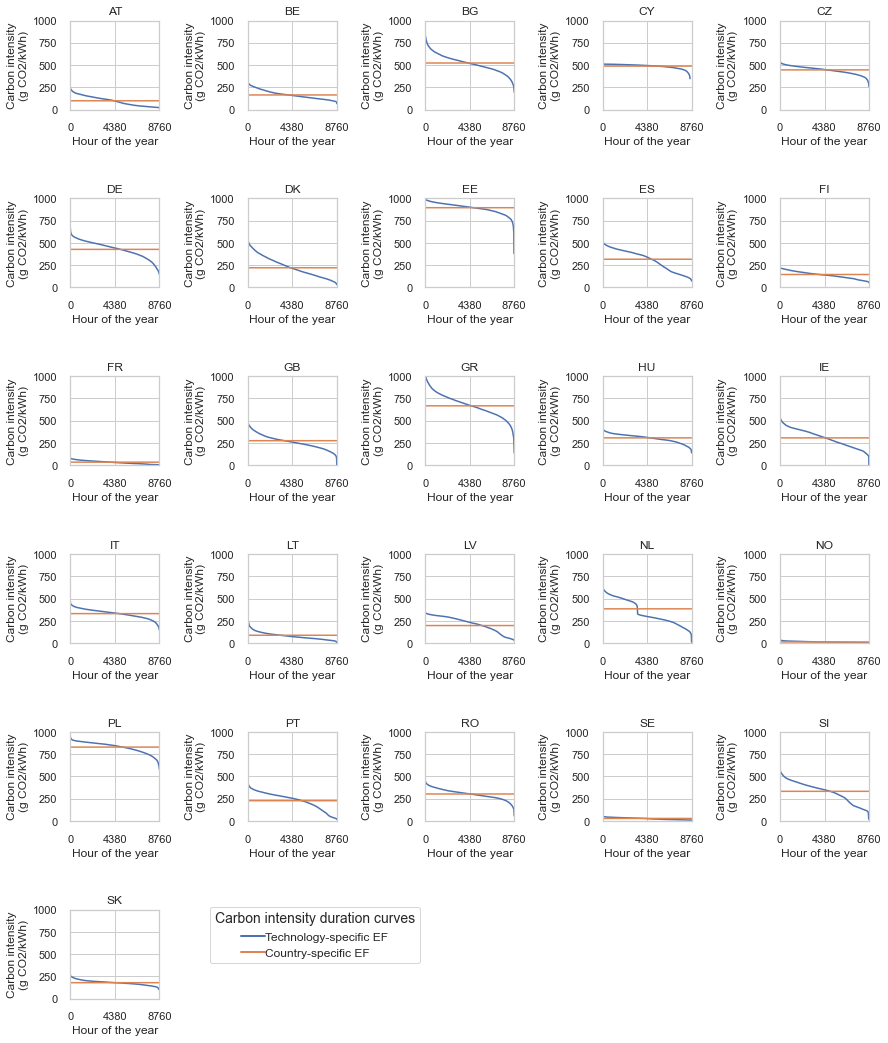

In [61]:
countries = c # Carbon_intensitiy_entsoe_gen_type.columns
n_graphs = len(c) #Carbon_intensitiy_entsoe_gen_type.columns)
#n_graphs = len(Carbon_intensitiy_entsoe_gen_type[EF.index.levels[0]].columns)

n_cols = 5
    
if n_graphs % n_cols == 0:
    n_rows = n_graphs // n_cols
else:
    n_rows = n_graphs // n_cols + 1
    
    
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)

fig.delaxes(axes[5][1])
fig.delaxes(axes[5][2])
fig.delaxes(axes[5][3])
fig.delaxes(axes[5][4])


size = 2.5

fig.set_size_inches(size*n_cols,size*n_rows)
    
    
for i, country in enumerate(c):
    i_row = i // n_cols
    i_col = i % n_cols
        
    ax = axes[i_row,i_col]
        
    ax.plot(range(0,8760), Carbon_intensitiy_entsoe_gen_type[country].sort_values(ascending=False))
    ax.plot(range(0,8760), ([mean_Carbon_intensitiy_entsoe_gen_type[country]]*8760))
    
    ax.set_title(country, fontsize=12)
    ax.set_xlim(0,8760)
    ax.set_ylim(0,1000)
    
    ax.set_xticks([0,4380,8760])
        
    ax.set_xlabel("Hour of the year", fontsize=12)
    ax.set_ylabel("Carbon intensity\n(g CO2/kWh)", fontsize=12)
    ax.set_aspect(8.760)
    fig.tight_layout()

handles = [Line2D([0], [0], color='C0', lw=2),
           Line2D([0], [0], color='C1', lw=2)
           ]
    
labels = ['Technology-specific EF','Country-specific EF']
    
l2 = ax.legend(handles, labels,  loc='upper left', bbox_to_anchor=(1.50, 1.10),
                   handletextpad=0., columnspacing=0.5, ncol=1,
                   title='Carbon intensity duration curves', fontsize=12, title_fontsize= 14, frameon=True)



In [62]:
fig.savefig(os.path.join(output_directory_path + '/CO2_duration_curve.png'),bbox_extra_artists=(l2,), bbox_inches='tight')

### Carbon Intensity Heat Map 

<AxesSubplot:xlabel='utc_timestamp', ylabel='region'>

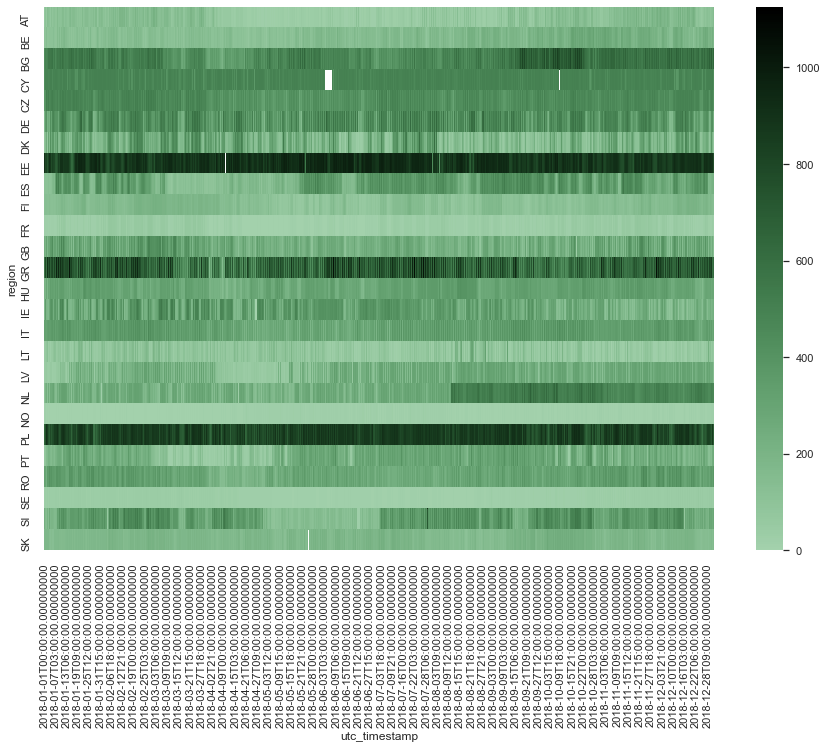

In [63]:
# all countries
sns.heatmap(Carbon_intensitiy_entsoe_gen_type[countries].transpose(), cmap=sns.cubehelix_palette(start=2, rot=0, dark=0, light=.75, reverse=False, as_cmap=True))

In [64]:
# use Germany as an aingle country example
df = Carbon_intensitiy_entsoe_gen_type['DE'].to_frame().copy()

In [65]:
df.head()

,DE
utc_timestamp,
2018-01-01 00:00:00+00:00,199.522307
2018-01-01 01:00:00+00:00,198.561804
2018-01-01 02:00:00+00:00,195.428854
2018-01-01 03:00:00+00:00,195.845125
2018-01-01 04:00:00+00:00,193.798527


In [66]:
# def names for the heat map
df['month'] = df.index.month_name()
df['day'] = df.index.day_name()
df['hour']=df.index.hour
df['date']=df.index.date
df.head()

,DE,month,day,hour,date
utc_timestamp,,,,,
2018-01-01 00:00:00+00:00,199.522307,January,Monday,0,2018-01-01
2018-01-01 01:00:00+00:00,198.561804,January,Monday,1,2018-01-01
2018-01-01 02:00:00+00:00,195.428854,January,Monday,2,2018-01-01
2018-01-01 03:00:00+00:00,195.845125,January,Monday,3,2018-01-01
2018-01-01 04:00:00+00:00,193.798527,January,Monday,4,2018-01-01


In [67]:
# group the values
df1 = df.groupby(['month', 'hour'],sort=False).agg(['mean'])
df1.columns=df1.columns.droplevel(0)
df1.reset_index(inplace=True)
df1.head()

,month,hour,mean
0,January,0,373.678439
1,January,1,370.911668
2,January,2,369.267070
3,January,3,371.891556
4,January,4,382.087786


In [68]:
# pandas pivot with multiple variables
heatmap_data = pd.pivot_table(df1, values='mean', index=['month'], columns='hour')
# print to see few rows and columns
print(heatmap_data.iloc[0:3, 0:3])

hour               0           1           2
month                                       
April     433.756252  430.297106  432.482288
August    496.989431  497.420347  501.089016
December  354.023624  352.800456  352.937431


In [69]:
months=df1.month.unique().tolist()
print(months)

['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


In [70]:
heatmap_data=heatmap_data.loc[months]

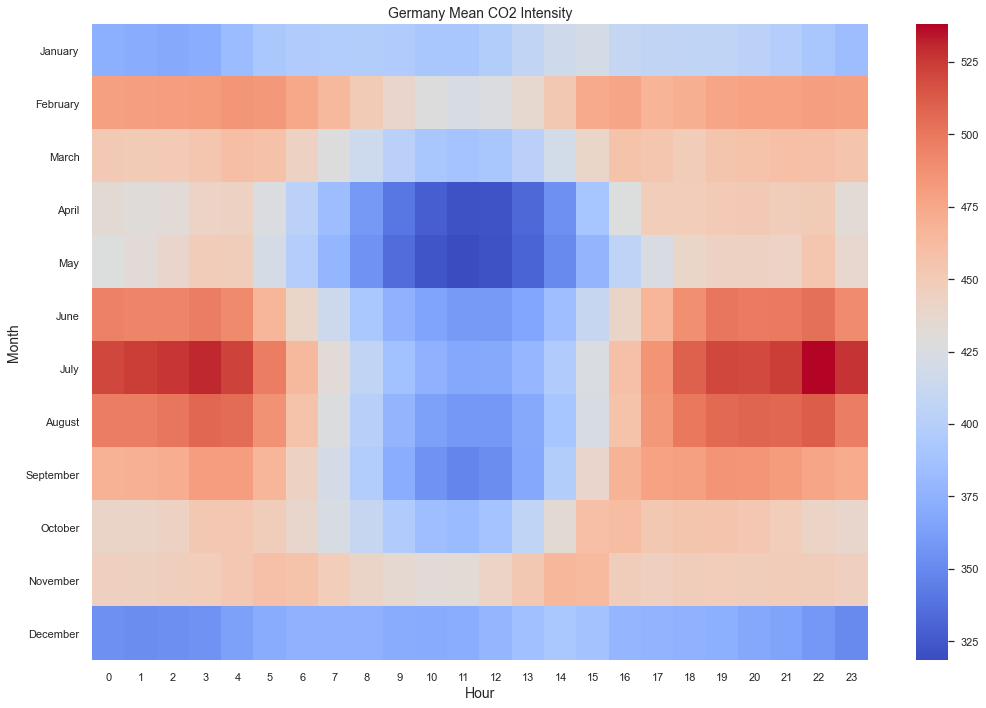

In [71]:
sns.heatmap(heatmap_data,cmap="coolwarm")
plt.xlabel("Hour", size=14)
plt.ylabel("Month", size=14)
plt.title("Germany Mean CO2 Intensity", size=14)
plt.tight_layout()

# Export final CO2 signals

In [72]:
Carbon_intensitiy_entsoe_gen_type.to_csv(processed_directory_path + '/CI_bottom_up_method.csv')
Carbon_intensitiy_entsoe_gen_type.to_csv(output_directory_path + '/CI_bottom_up_method.csv')